# Plant Disease Detection

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import liberaries and models

In [53]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, Dropout
from tensorflow.keras.models import Model 
from tensorflow.keras.applications.inception_v3 import InceptionV3 
from tensorflow.keras.applications.inception_v3 import preprocess_input 
from tensorflow.keras.preprocessing import image 
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img 
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras import models 
from tensorflow.keras import layers 
from sklearn.model_selection import train_test_split
import tensorflow as tf 
import os
import tensorflow_datasets as tfds
import numpy as np
import glob 
import matplotlib.pyplot as plt 
from keras.models import load_model

## Get the Data

In [3]:
imageSize = 224
batchSize = 20

In [4]:
dataSet = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/drive/MyDrive/AgriWise/ML/plant diseases/new model/train2",
    shuffle = True, 
    image_size = (imageSize, imageSize),
    batch_size = batchSize
)

Found 5000 files belonging to 25 classes.


## Data Exploraion

In [48]:
Categories = dataSet.class_names
Categories

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [6]:
len(dataSet)

250

In [7]:
for image_batch, label_batch in dataSet.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(20, 224, 224, 3)
[13 17 16  9 23  5 16 11 19 18  8 12 14 10 20 15 24 20  0 16]


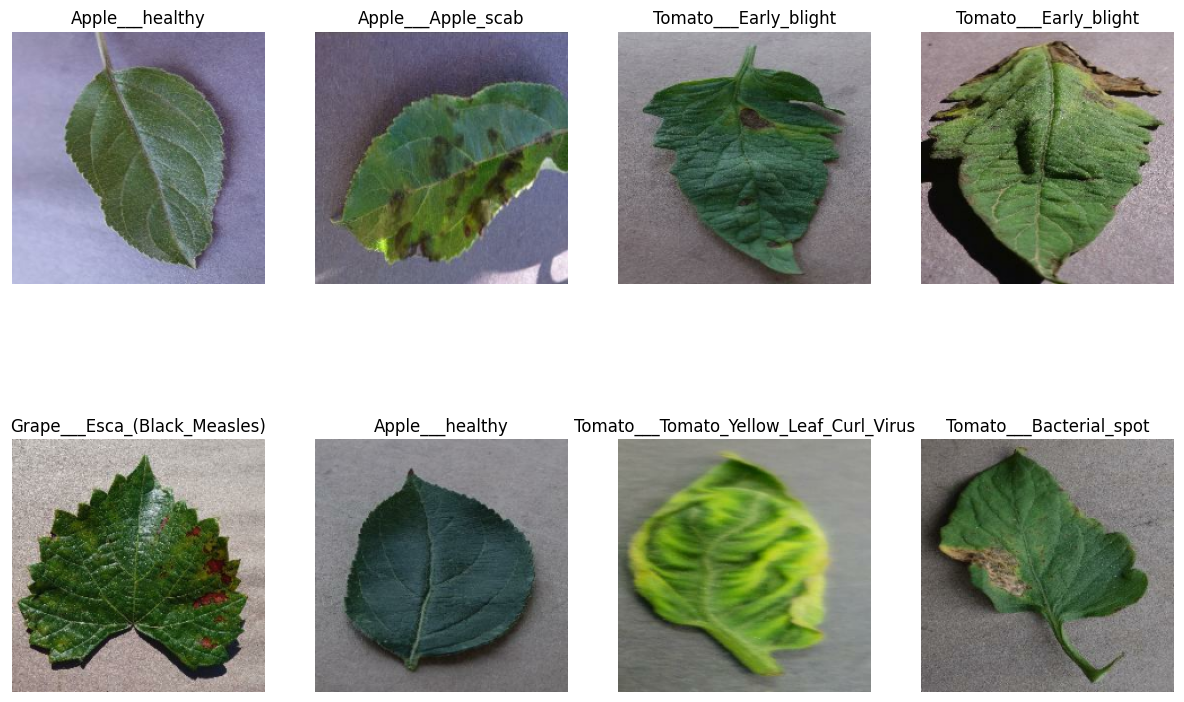

In [54]:
plt.figure(figsize=(15, 15))
for image_batch, label_batch in dataSet.take(2):
    for i in range(8):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) 
        plt.title(Categories[label_batch[i]])
        plt.axis("off")

In [9]:
def train_valid_split(dataset, train_split = 0.8, valid_split=0.2, shuffle=True, shuffle_size=10000):
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    
    n_train = train_split * len(dataset)
    train_data = dataset.take(int(n_train))
    valid_data = dataset.skip(int(n_train))

    print("Train size: ",len(train_data))
    print("Valid size: ", len(valid_data))
    return train_data, valid_data

In [10]:
trainSet, validSet = train_valid_split(dataSet)

Train size:  200
Valid size:  50


In [11]:
trainSet = trainSet.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validSet = validSet.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## MobileNet

In [12]:
rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(imageSize, imageSize),
    layers.experimental.preprocessing.Rescaling(1.0/imageSize)
])

In [30]:
inputShape=(batchSize, imageSize, imageSize,3)

In [31]:
import tensorflow_hub as hub
from tensorflow_hub import KerasLayer
mobileNet = 'https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4'

In [32]:
nClasses = len(Categories)

with CustomObjectScope({'KerasLayer': tf.keras.layers.Layer}):
    model =models.Sequential([
    rescale,
    tf.keras.layers.InputLayer(input_shape=inputShape, dtype=tf.float32),
    KerasLayer(mobileNet,trainable=False,dtype=tf.float32),
    Flatten(),
    Dense(1024,activation='relu'),
    Dense(512,activation='relu'),
    Dense(256,activation='relu'),
    Dense(nClasses,activation='softmax')
])

In [33]:
model.build(inputShape)

In [34]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 input_3 (InputLayer)        multiple                  0         
                                                                 
 keras_layer_2 (KerasLayer)  (20, 1280)                2257984   
                                                                 
 flatten_2 (Flatten)         (20, 1280)                0         
                                                                 
 dense_8 (Dense)             (20, 1024)                1311744   
                                                                 
 dense_9 (Dense)             (20, 512)                 524800    
                                                                 
 dense_10 (Dense)            (20, 256)                

In [35]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [36]:
n_epochs = 20

history = model.fit(
    trainSet,
    epochs = n_epochs, 
    batch_size = batchSize,
    verbose=1,
    validation_data=validSet
)

Epoch 1/20
200/200 [==============================] - 21s 56ms/step - loss: 0.9275 - accuracy: 0.7143 - val_loss: 0.3979 - val_accuracy: 0.8670
Epoch 2/20
200/200 [==============================] - 7s 35ms/step - loss: 0.3327 - accuracy: 0.8892 - val_loss: 0.3136 - val_accuracy: 0.8950
Epoch 3/20
200/200 [==============================] - 7s 36ms/step - loss: 0.2485 - accuracy: 0.9208 - val_loss: 0.2887 - val_accuracy: 0.9050
Epoch 4/20
200/200 [==============================] - 7s 33ms/step - loss: 0.1622 - accuracy: 0.9460 - val_loss: 0.1846 - val_accuracy: 0.9430
Epoch 5/20
200/200 [==============================] - 7s 36ms/step - loss: 0.1291 - accuracy: 0.9563 - val_loss: 0.2197 - val_accuracy: 0.9400
Epoch 6/20
200/200 [==============================] - 7s 34ms/step - loss: 0.1071 - accuracy: 0.9647 - val_loss: 0.1064 - val_accuracy: 0.9640
Epoch 7/20
200/200 [==============================] - 7s 35ms/step - loss: 0.0589 - accuracy: 0.9840 - val_loss: 0.1279 - val_accuracy: 0.962

In [43]:
def draw_acc_loss(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(1, len(acc) + 1)
  #Train and validation accuracy
  plt.plot(epochs, acc, 'b', label='Training accurarcy')
  plt.plot(epochs, val_acc, 'g', label='Validation accurarcy')
  plt.title('Training and Validation accurarcy')
  plt.legend()
  plt.figure()
  #Train and validation loss
  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'g', label='Validation loss')
  plt.title('Training and Validation loss')
  plt.legend()
    
  plt.show()

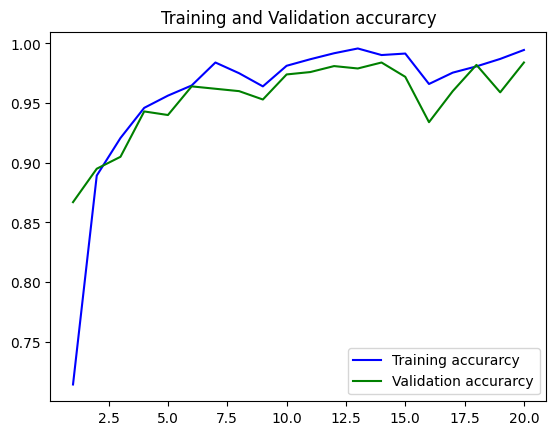

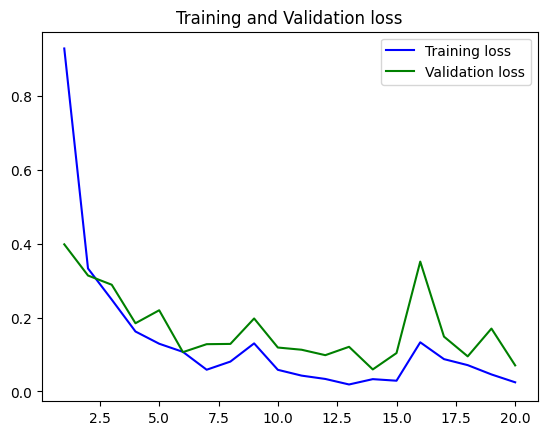

In [44]:
draw_acc_loss(history)

In [39]:
model.save('Plant Disease Detection.h5')

In [45]:
import json
import joblib
joblib.dump(history, "./Plant Disease Detection.joblib", compress=True)

['./final.joblib']

## Testing

In [49]:
#from tensorflow.keras.preprocessing import image

# Load the saved model
with CustomObjectScope({'KerasLayer': tf.keras.layers.Layer}):
    model = tf.keras.models.load_model('Plant Disease Detection.h5', custom_objects={'KerasLayer':hub.KerasLayer})


# Load the image and preprocess it
imagePath = '/content/drive/MyDrive/AgriWise/ML/plant diseases/test/Corn_(maize)___Common_rust_/RS_Rust 1792_flipLR.JPG'
img = image.load_img(imagePath, target_size=(224, 224))
imageArray = image.img_to_array(img)
imageArray = np.expand_dims(imageArray, axis=0)

# Make a prediction
prediction = model.predict(imageArray)

# Print the predicted class
categories = Categories
predicted_class = np.argmax(prediction)
print(categories[predicted_class])

1/1 [==============================] - 1s 527ms/step
Corn_(maize)___Common_rust_


In [52]:
imagePath = '/content/drive/MyDrive/AgriWise/ML/plant diseases/test/Potato___healthy/03da9931-e514-4cc7-b04a-8f474a133ce5___RS_HL 1830_new30degFlipLR.JPG'
img = image.load_img(imagePath, target_size=(224, 224))
imageArray = image.img_to_array(img)
imageArray = np.expand_dims(imageArray, axis=0)


# Make a prediction
prediction = model.predict(imageArray)

# Print the predicted class
categories = Categories
predicted_class = np.argmax(prediction)
print(categories[predicted_class])

1/1 [==============================] - 0s 42ms/step
Potato___healthy
